In [58]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial

import halomod

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.preprocessing.accretion import *
from dm21cm.preprocessing.halo import *
from dm21cm.preprocessing.hmf import *
from dm21cm.utils import load_h5_dict

sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as phys

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../plotting/matplotlibrc')

# 1. BHL and PR accretion

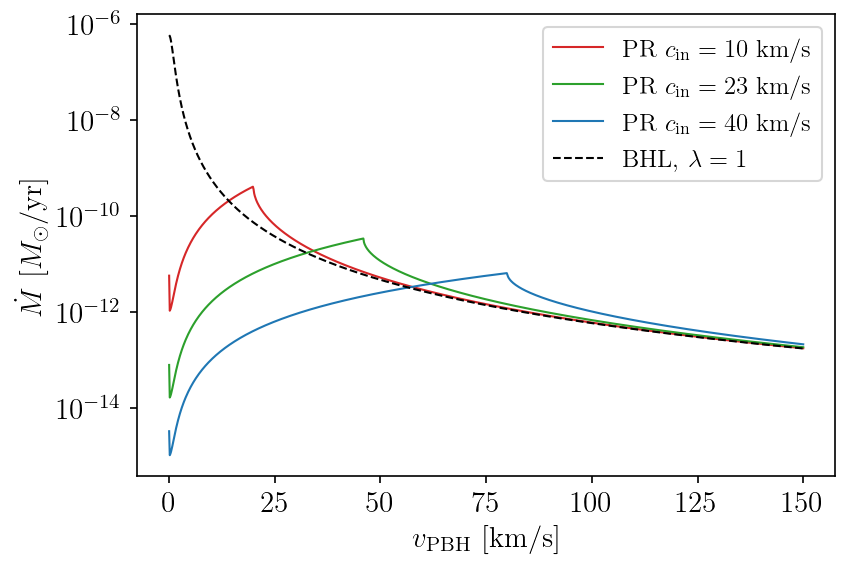

In [2]:
rho_inf = c.m_p.to(u.g).value * 1e3 # [g/cm^3]
c_inf = 1 # [km/s]
c_in = 23 # [km/s]
M = 10 # [M_sun]
v_arr = np.linspace(0.01, 150, 1000) # [km/s]
Mdot_PR10_arr = np.array([Mdot_PR(M, rho_inf, v, 10, c_inf) for v in v_arr])
Mdot_PR23_arr = np.array([Mdot_PR(M, rho_inf, v, 23, c_inf) for v in v_arr])
Mdot_PR40_arr = np.array([Mdot_PR(M, rho_inf, v, 40, c_inf) for v in v_arr])
Mdot_BHL_arr = np.array([Mdot_BHL(M, rho_inf, v, None, c_inf) for v in v_arr])

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.plot(v_arr, Mdot_PR10_arr, label=r'PR $c_\mathrm{in}=10$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR23_arr, label=r'PR $c_\mathrm{in}=23$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR40_arr, label=r'PR $c_\mathrm{in}=40$ km/s', lw=1)
axs.plot(v_arr, Mdot_BHL_arr, 'k--', label=r'BHL, $\lambda=1$', lw=1)
axs.set(yscale='log')
axs.set(xlabel=r'$v_\mathrm{PBH}$ [km/s]', ylabel=r'$\dot{M}$ [$M_\odot$/yr]')
axs.legend()
fig.savefig('Mdot_PR_BHL.pdf', bbox_inches='tight')

# 2. Cosmological PBH: injected energy vs. redshift

$$f(v)dv=\left(\frac{m}{2\pi kT}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{mv^2}{2kT}\right]dv=\left(\frac{3}{2\pi v_\text{rms}^2}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{3v^2}{2v_\text{rms}^2}\right]dv, \qquad v_\text{rms}^2 = \frac{3kT}{m}$$

In [2]:
z_arr = np.linspace(5, 1000, 100)

M_PBH = 100 # [M_sun]
f_PBH = 1.
c_in = 23 # [km/s]

Mdot_BHL_v = jax.jit(jax.vmap(Mdot_BHL, in_axes=(None, None, 0, None, None)))
Mdot_PR_v = jax.jit(jax.vmap(Mdot_PR, in_axes=(None, None, 0, None, None)))

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
def L_ADAF_BHL_v(M_PBH, rho_inf, v, c_in, c_inf):
    Mdot = Mdot_BHL(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]
    return L_ADAF(Mdot, M_PBH)

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
def L_ADAF_PR_v(M_PBH, rho_inf, v, c_in, c_inf):
    Mdot = Mdot_PR(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]
    return L_ADAF(Mdot, M_PBH)

vars = ['Mdot_BHL', 'Mdot_PR', 'L_BHL', 'L_PR']
var_dict = {k : [] for k in vars}
func_dict = {
    'Mdot_BHL' : Mdot_BHL_v,
    'Mdot_PR' : Mdot_PR_v,
    'L_BHL' : L_ADAF_BHL_v,
    'L_PR' : L_ADAF_PR_v,
}

for i, z in enumerate(tqdm(z_arr)):

    n_PBH = f_PBH * (cosmo.critical_density(z) * cosmo.Odm(z) / (M_PBH * u.M_sun)).to(u.cm**-3).value # [cm^-3]
    rho_inf = (cosmo.critical_density(z) * cosmo.Ob(z)).to(u.g/u.cm**3).value # [g/cm^3]
    T_K = phys.Tm_std(1+z) # [eV]
    c_inf = np.sqrt(5/3 * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
    v_cb = v_cb_cosmo(z) # [km/s]

    v_max = 10 * v_cb
    v_min = v_cb / 10
    v_s = jnp.linspace(v_min, v_max, 1000)
    fv_s = f_MB(v_s, v_cb)

    for k in vars:
        v_integrand = func_dict[k](M_PBH, rho_inf, v_s, c_in, c_inf)
        v_integral = jnp.trapz(v_integrand * fv_s, v_s)
        var_dict[k].append(v_integral)
var_dict = {k : jnp.array(v) for k, v in var_dict.items()}

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 80.58it/s]


Text(0.5, 0.98, 'Cosmological contribution')

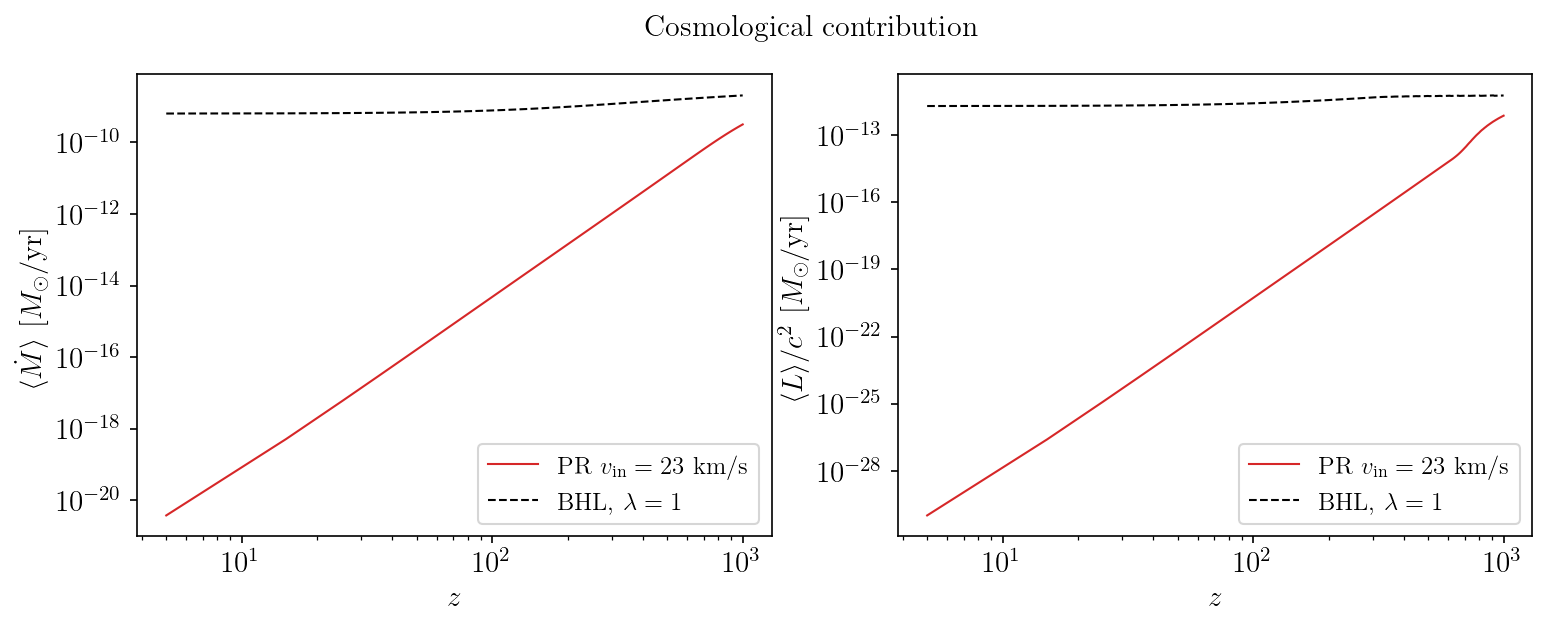

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(z_arr, var_dict['Mdot_PR'], lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[0].plot(z_arr, var_dict['Mdot_BHL'], 'k--', lw=1, label='BHL, $\lambda=1$')
axs[0].set(xscale='log', yscale='log')
axs[0].set(xlabel=r'$z$', ylabel=r'$\langle\dot{M}\rangle$ [$M_\odot$/yr]')
axs[0].legend()

axs[1].plot(z_arr, var_dict['L_PR'], lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[1].plot(z_arr, var_dict['L_BHL'], 'k--', lw=1, label='BHL, $\lambda=1$')
axs[1].set(xscale='log', yscale='log')
axs[1].set(xlabel=r'$z$', ylabel=r'$\langle L\rangle/c^2$ [$M_\odot$/yr]')
axs[1].legend()

fig.suptitle('Cosmological contribution')

# 3. Halo contribution: Example halo

## 3.1 CMZ

In [71]:
def cmz(m, z):
    hm = halomod.DMHaloModel(
        halo_concentration_model='Ludlow16',
        z = z, Mmin = 0., Mmax = 19, dlog10m = 0.025,
        mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
    )
    hm_m_s, hm_cmz_s = fix_cmz_numerical_issues(hm.m, hm.cmz_relation)
    return np.interp(np.log(m), np.log(hm_m_s), hm_cmz_s)

$$L_\text{halo}=\int_V n_\text{PBH}L_\text{PBH}=\frac{f}{M_\text{PBH}}\int_0^{r_\Delta}4\pi r^2dr \rho(r)L()$$

In [73]:
m_PBH = 100 # [M_sun]
f_PBH = 1
c_in = 23 # [km/s]
z = 10
m_halo = 1e8 # [M_sun]
c_halo = cmz(m_halo, z)

print(f'c = {c_halo:.4f}')

c = 4.1005


In [74]:
KM_PER_PC = (u.pc).to(u.km)

rho_s, r_s, r_delta = nfw_info(m_halo, c_halo, z)
print(f'rho_s = {rho_s:.4e} M_sun / pc^3')
print(f'r_s = {r_s:.4f} pc')
print(f'r_delta = {r_delta:.4f} pc')

rho_s = 7.3566e-02 M_sun / pc^3
r_s = 319.9855 pc
r_delta = 1312.0986 pc


$$v_\text{rms}^2 = \frac{3kT}{m}\qquad c_\infty^2 = \frac{5kT}{3m}\quad\Rightarrow\quad c_\infty=\sqrt{\frac{5}{9}}~v_\text{rms}$$

In [6]:
# common parameters
M_PBH = 100 # [M_sun]
f_PBH = 1.
c_in = 23 # [km/s]

f_DM = cosmo.Odm0 / cosmo.Om0
f_SM = cosmo.Ob0 / cosmo.Om0

# at various radius
r_list = [1e-4 * r_s, 1e-3 * r_s, 1e-2 * r_s, 1e-1 * r_s, r_s, 0.9 * r_delta]
v_km_s_list = []
L_s_list = []
f_s_list = []
n_PBH_list = []

for r in r_list:
    ve = get_ve(r, rho_s, r_s, r_delta)
    v0 = get_v0_jeans(r, rho_s, r_s, r_delta)
    rho = nfw_density(r, rho_s, r_s) # [M_sun/pc^3]
    n_PBH = f_PBH * f_DM * (rho * u.M_sun / u.pc**3 / (M_PBH * u.M_sun)).to(u.pc**-3).value # [pc^-3]
    n_PBH_list.append(n_PBH)
    rho_inf = f_SM * (rho * u.M_sun / u.pc**3).to(u.g/u.cm**3).value # [g/cm^3]

    # cosmological values
    # T_K = phys.Tm_std(1+z) # [eV]
    # c_inf = np.sqrt(5/3 * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
    c_inf = jnp.sqrt(5/9) * v0 * KM_PER_PC

    print()
    print(f'r = {r:.4e} pc')
    print(f'n_PBH = {n_PBH:.4e} pc^-3')
    print(f'rho_inf = {rho_inf:.4e} g/cm^3')
    print(f'c_inf = {c_inf:.4f} km/s')
    

    v_pc_s = jnp.linspace(0, ve, 1000)
    v_km_s = v_pc_s * KM_PER_PC
    v_km_s_list.append(v_km_s)
    L_s = L_ADAF_PR_v(M_PBH, rho_inf, v_km_s, c_in, c_inf)
    L_s_list.append(L_s)

    f_s = dm_rest_v_rel_dist_unnorm(v_pc_s, ve, v0)
    f_s /= jnp.trapz(f_s, v_km_s)
    f_s_list.append(f_s)


r = 3.1999e-02 pc
n_PBH = 2.4768e+01 pc^-3
rho_inf = 3.1488e-20 g/cm^3
c_inf = 0.8281 km/s

r = 3.1999e-01 pc
n_PBH = 2.4723e+00 pc^-3
rho_inf = 3.1432e-21 g/cm^3
c_inf = 2.1876 km/s

r = 3.1999e+00 pc
n_PBH = 2.4285e-01 pc^-3
rho_inf = 3.0874e-22 g/cm^3
c_inf = 5.2674 km/s

r = 3.1999e+01 pc
n_PBH = 2.0473e-02 pc^-3
rho_inf = 2.6029e-23 g/cm^3
c_inf = 10.3161 km/s

r = 3.1999e+02 pc
n_PBH = 6.1932e-04 pc^-3
rho_inf = 7.8736e-25 g/cm^3
c_inf = 12.8260 km/s

r = 1.1809e+03 pc
n_PBH = 3.0512e-05 pc^-3
rho_inf = 3.8791e-26 g/cm^3
c_inf = 5.8288 km/s


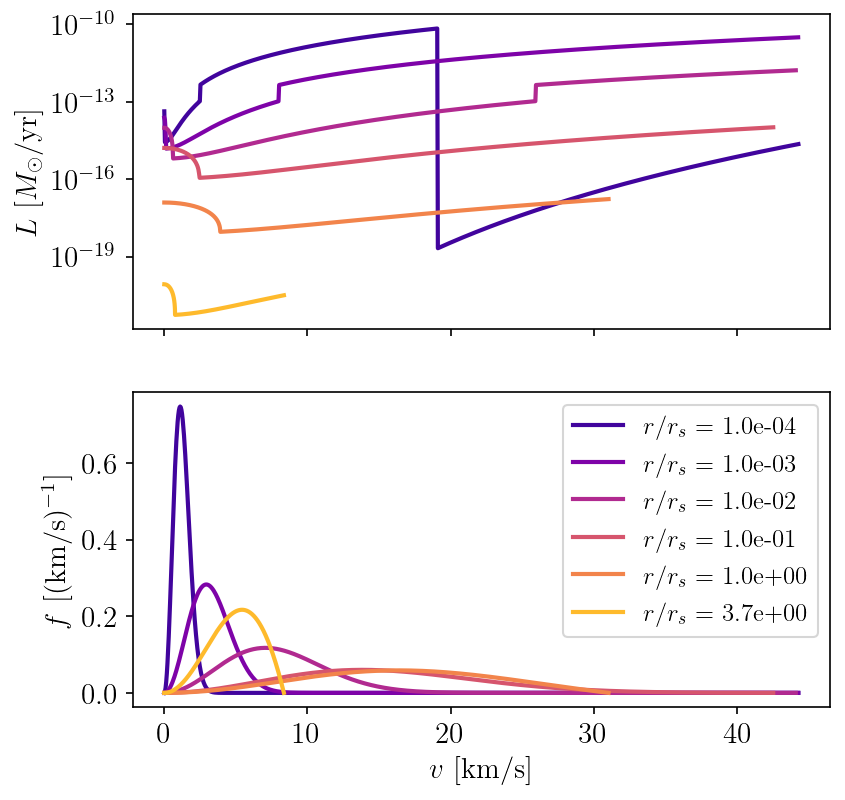

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for i in range(len(r_list)):
    x = 0.1 + 0.15 * i
    color = mpl.colormaps['plasma'](x)

    r = r_list[i]

    ax = axs[0]
    ax.plot(v_km_s_list[i], L_s_list[i], color=color, label=fr'$r/r_s$ = {r_list[i]/r_s:.2f}')
    ax.set(ylabel=r'$L$ [$M_\odot$/yr]')
    ax.set(yscale='log')
    
    ax = axs[1]
    ax.plot(v_km_s_list[i], f_s_list[i], color=color, label=fr'$r/r_s$ = {r_list[i]/r_s:.1e}')
    ax.set(xlabel=r'$v$ [km/s]', ylabel=r'$f$ [(km/s)$^{-1}$]')
    ax.legend()

fig.savefig('halo-L-f-v.pdf', bbox_inches='tight')

## 3.2 Organization

In [75]:
class PBHAccretionModel:

    def __init__(self, m_PBH, f_PBH, accretion_type, **kwargs):

        self.m_PBH = m_PBH
        self.f_PBH = f_PBH
        self.accretion_type = accretion_type

        if self.accretion_type == 'PR-ADAF':
            self.c_in = kwargs['c_in']
        else:
            raise NotImplementedError

In [76]:
am = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='PR-ADAF', c_in=23)
z = 10
m_halo = 1e8 # [M_sun]
c_halo = cmz(m_halo, z)

In [83]:
f_DM = cosmo.Odm0 / cosmo.Om0
f_SM = cosmo.Ob0 / cosmo.Om0
KM_PER_PC = (1 * u.pc).to(u.km).value

# reference values
rho_ref = 1
n_PBH_ref = am.f_PBH * f_DM * (rho_ref * u.M_sun / u.pc**3 / (am.m_PBH * u.M_sun)).to(u.pc**-3).value # [pc^-3]
rho_inf_ref = f_SM * (rho_ref * u.M_sun / u.pc**3).to(u.g/u.cm**3).value # [g/cm^3]

def L_halo(m_halo, c_halo, z, r_min_frac=1e-4):

    rho_s, r_s, r_delta = nfw_info(m_halo, c_halo, z)
    r_arr = jnp.geomspace(r_min_frac * r_s, 0.99 * r_delta, 300)

    @partial(jax.vmap, in_axes=(0,))
    def L_halo_integrand(r):
        
        # v-dist parameters
        ve = get_ve(r, rho_s, r_s, r_delta) # [pc/s]
        v0 = get_v0_jeans(r, rho_s, r_s, r_delta) # [pc/s]
        rho = nfw_density(r, rho_s, r_s) # [M_sun/pc^3]

        # accretion parameters
        n_PBH = n_PBH_ref * (rho / rho_ref) # [pc^-3]
        rho_inf = rho_inf_ref * (rho / rho_ref) # [g/cm^3]
        c_inf = jnp.sqrt(5/9) * v0 * KM_PER_PC # [km/s]
    
        # v integral
        v_pc_s = jnp.linspace(0, ve, 300)
        v_km_s = v_pc_s * KM_PER_PC
        f_s = dm_rest_v_rel_dist_unnorm(v_pc_s, ve, v0)
        f_s /= jnp.trapz(f_s, v_km_s)
        L_s = L_ADAF_PR_v(am.m_PBH, rho_inf, v_km_s, am.c_in, c_inf) # [M_sun/yr]
        L_v_expn = jnp.trapz(L_s * f_s, v_km_s) # [M_sun/yr]

        return 4 * jnp.pi * r**2 * n_PBH * L_v_expn # [M_sun/yr / pc]
    
    L_halo = jnp.trapz(L_halo_integrand(r_arr), r_arr) # [M_sun/yr]
    return L_halo

100000000.0 4.1004944355637845 10


[None]

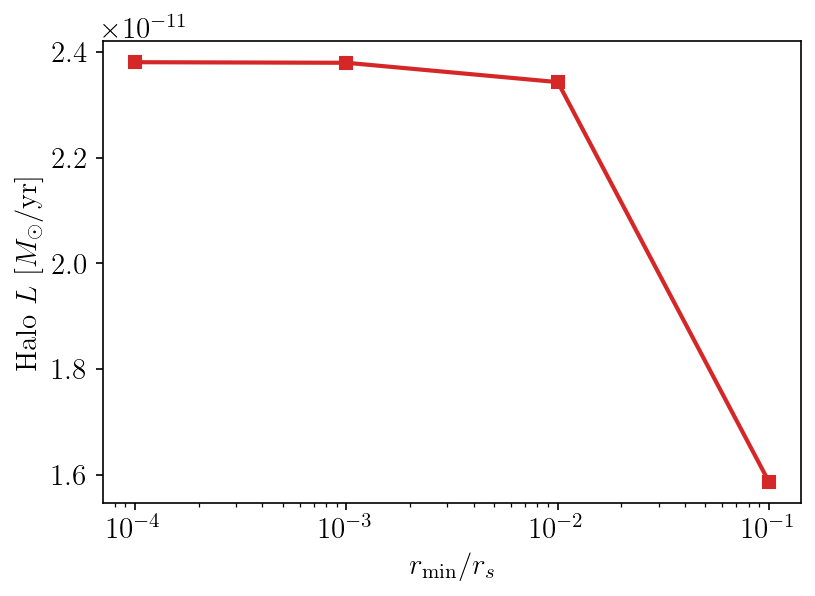

In [84]:
# convergence
print(m_halo, c_halo, z)

r_min_frac_s = [1e-4, 1e-3, 1e-2, 1e-1]
L_halo_s = []

L_halo_jit = jax.jit(L_halo)

for r_min_frac in r_min_frac_s:
    L_halo_s.append(L_halo_jit(m_halo, c_halo, z, r_min_frac=r_min_frac))

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
ax.plot(r_min_frac_s, L_halo_s, 's-')
ax.set(xlabel=r'$r_\mathrm{min}/r_s$', ylabel=r'Halo $L$ [$M_\odot$/yr]')
ax.set(xscale='log');

# fig.savefig('halo-L-r-convergence.pdf', bbox_inches='tight')

# 4. Sum over HMF

In [85]:
hmfd = load_h5_dict("../../data/pwave/m_data.h5")

m_s = hmfd['m_range'] # [M_sun]
z_s = hmfd['z_range']
dndm_PS = hmfd['dNdM'] # [M_sun^-1 Mpc^-3]
print(dndm_PS.shape)
dndm_ST = hmfd['dNdM_ST'] # [M_sun^-1 Mpc^-3]

(51, 4001)


## 4.1 $f_\mathrm{coll}$

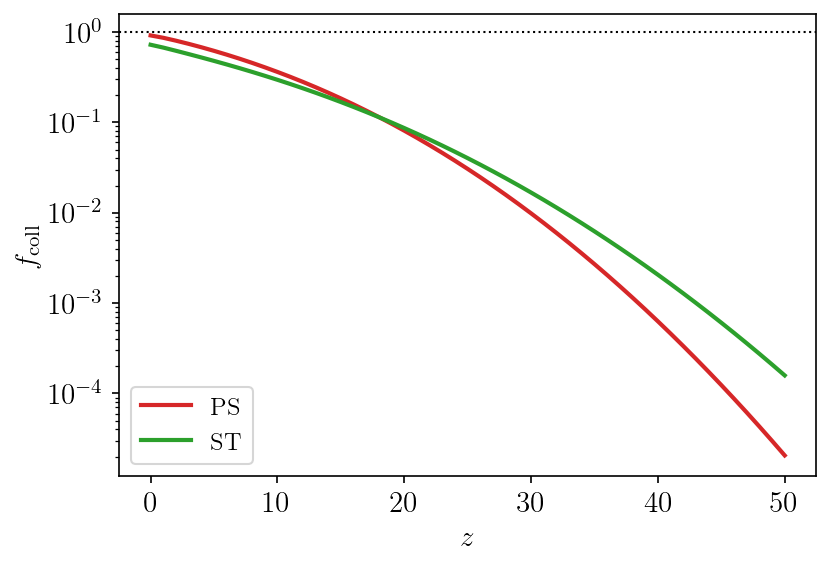

In [86]:
# collapsed fraction
rho_coll_PS = np.trapz(m_s[None, :] * dndm_PS, m_s, axis=1) # [M_sun cMpc^-3]
rho_coll_ST = np.trapz(m_s[None, :] * dndm_ST, m_s, axis=1) # [M_sun cMpc^-3]
f_coll_PS = rho_coll_PS / RHO_M # RHO_M is for present day [M_sun cMpc^-3]
f_coll_ST = rho_coll_ST / RHO_M

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
ax.plot(z_s, f_coll_PS, label='PS')
ax.plot(z_s, f_coll_ST, label='ST')
ax.set(yscale='log')
ax.axhline(1, color='k', ls=':', lw=1)
ax.set(xlabel=r'$z$', ylabel=r'$f_\mathrm{coll}$')
ax.legend()

## 4.2 L-m

In [87]:
# Resample m_s
hmfd = load_h5_dict("../../data/pwave/m_data.h5")

res_m = 1000
m_s = np.geomspace(hmfd['m_range'][0], hmfd['m_range'][-1], res_m)
dndm_PS = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM'][i])) for i in range(len(z_s))])
dndm_ST = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM_ST'][i])) for i in range(len(z_s))])

/tmp/ipykernel_1188769/1559452433.py:6: RuntimeWarning: divide by zero encountered in log
  dndm_PS = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM'][i])) for i in range(len(z_s))])
/tmp/ipykernel_1188769/1559452433.py:7: RuntimeWarning: divide by zero encountered in log
  dndm_ST = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM_ST'][i])) for i in range(len(z_s))])


In [96]:
am = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='PR-ADAF', c_in=23)
z = 12
m_halo_s = jnp.asarray(m_s) # [M_sun]
c_halo_s = jnp.asarray(cmz(m_halo_s, z))

In [97]:
f_DM = cosmo.Odm0 / cosmo.Om0
f_SM = cosmo.Ob0 / cosmo.Om0
KM_PER_PC = (1 * u.pc).to(u.km).value

# reference values
rho_ref = 1
n_PBH_ref = am.f_PBH * f_DM * (rho_ref * u.M_sun / u.pc**3 / (am.m_PBH * u.M_sun)).to(u.pc**-3).value # [pc^-3]
rho_inf_ref = f_SM * (rho_ref * u.M_sun / u.pc**3).to(u.g/u.cm**3).value # [g/cm^3]

@partial(jax.vmap, in_axes=(0, 0, None, None))
def L_halo(m_halo, c_halo, z, r_min_frac):

    rho_s, r_s, r_delta = nfw_info(m_halo, c_halo, z)
    r_arr = jnp.geomspace(r_min_frac * r_s, 0.99 * r_delta, 300)

    @partial(jax.vmap, in_axes=(0,))
    def L_halo_integrand(r):
        
        # v-dist parameters
        ve = get_ve(r, rho_s, r_s, r_delta) # [pc/s]
        v0 = get_v0_jeans(r, rho_s, r_s, r_delta) # [pc/s]
        rho = nfw_density(r, rho_s, r_s) # [M_sun/pc^3]

        # accretion parameters
        n_PBH = n_PBH_ref * (rho / rho_ref) # [pc^-3]
        rho_inf = rho_inf_ref * (rho / rho_ref) # [g/cm^3]
        c_inf = jnp.sqrt(5/9) * v0 * KM_PER_PC # [km/s]
    
        # v integral
        v_pc_s = jnp.linspace(0, ve, 300)
        v_km_s = v_pc_s * KM_PER_PC
        f_s = dm_rest_v_rel_dist_unnorm(v_pc_s, ve, v0)
        f_s /= jnp.trapz(f_s, v_km_s)
        L_s = L_ADAF_PR_v(am.m_PBH, rho_inf, v_km_s, am.c_in, c_inf) # [M_sun/yr]
        L_v_expn = jnp.trapz(L_s * f_s, v_km_s) # [M_sun/yr]

        return 4 * jnp.pi * r**2 * n_PBH * L_v_expn # [M_sun/yr / pc]
    
    L_halo = jnp.trapz(L_halo_integrand(r_arr), r_arr) # [M_sun/yr]
    return L_halo

In [ ]:
L_halo(m_halo_s, c_halo_s, z, 1e-4)